In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from copy import deepcopy
from scipy.spatial.transform import Rotation as ScipyRot
import matplotlib.pyplot as plt

# SUPPORTING FUNCTIONS

In [2]:
def function_S(input):
    # input should be array
    # output array
    flattened_input = input.flatten()
    output = [[0,           -flattened_input[2],    flattened_input[1]],
              [flattened_input[2],  0,              -flattened_input[0]],
              [-flattened_input[1], flattened_input[0],     0]]
    return np.array(output)

In [3]:
def rodrigues_formula(quaternion):
    '''
    quaternion -> R_tilde_bar
    input: [w,x,y,z]
    output R_tile_bar (rotation matrix)
    From page6
    '''
    return np.eye(3) + 2*np.matmul(function_S(quaternion[1:]), (quaternion[0]*np.eye(3) + function_S(quaternion[1:])))


In [4]:
def function_A(omega):
    A11 = function_S(-omega)
    A12 = np.zeros((3,3))
    A21 = np.zeros((3,3))
    A22 = function_S(-omega)
    return np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))


In [5]:
def function_Pi(input):
    '''
    Pi_x := I_3 - xx^T
    input: array
    output P_x
    '''
    return np.eye(3) - np.matmul(input, np.transpose(input))

In [6]:
def function_d(input_rot, input_p, input_z, with_noise):
    '''
    calculate d_i(t) := R^T(t)(p(t) - z_i)/|p(t)-z_i|
    '''
    norm = (input_p - input_z)/np.linalg.norm(input_p - input_z)
    dir = np.matmul(np.transpose(input_rot), norm)
    if with_noise:
        '''
        calculate noisy d = sign(d_{i,3}) / demon (d_{i,1}/d_{i,3} + n_{n,1}, d_{i,2}/d_{i,3} + n_{i,2}, 1).T
        demon = sqrt((d_{i,1}/d_{i,3} + n_{n,1})^2 + (d_{i,2}/d_{i,3} + n_{i,2})^2 + 1)
        '''
        dir = dir.flatten()
        n_1 = np.random.uniform(-0.005, 0.005, 1)[0]
        n_2 = np.random.uniform(-0.005, 0.005, 1)[0]
        d1_d3 = dir[0]/dir[2] + n_1
        d2_d3 = dir[1]/dir[2] + n_2
        demon = np.sqrt(d1_d3**2 + d2_d3**2 + 1)
        dir = (np.sign(dir[2])/ demon) * np.array([[d1_d3, d2_d3, 1]]).T
    return dir

In [7]:
def function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks):
    for landmark_idx in range(num_landmarks):
        # S(R_hat.T x z)
        first = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
        second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        final = -np.matmul(first, second)
        C_landmark = np.hstack((final, first))
        if landmark_idx == 0:
            output_C = C_landmark
        else:
            output_C = np.vstack((output_C, C_landmark))
    return output_C

In [8]:
def add_bar(input_rot, input_p):
    return np.matmul(np.transpose(input_rot), input_p)

In [9]:
def remove_bar(input_rot, input_p_bar):
    return np.matmul(np.linalg.inv(np.transpose(input_rot)), input_p_bar)

# SIMULATION

In [10]:
def plot_output(which_eq, noise, save_graph):
    if noise:
        name = "_with_noise.png"
    else:
        name = "_without_noise.png"
    figure = plt.subplot()

    plot_est_p = []
    plot_act_p = []
    for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    plt.plot(sol.t, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"])
    plt.xlim(0)
    plt.ylim(-0.5, 0.5)
    plt.legend(loc="upper right")
    plt.title("pose")
    plt.grid()
    plt.minorticks_on()
    plt.savefig("/home/annika/ITRL/kth_thesis/eq" + str(which_eq) + "_pose" + name, format='png', dpi=300)

    plt.show()

    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
        err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)

    plt.plot(sol.t, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
    plt.xlim(0)
    plt.ylim(-0.1, 0.1)
    plt.legend(loc="upper right")
    plt.title("orientation")
    plt.grid()
    plt.minorticks_on()
    plt.savefig("/home/annika/ITRL/kth_thesis/eq" + str(which_eq) + "_orientation" + name, format='png', dpi=300)
    plt.show()

In [11]:
def data_to_csv(noise):
    import pandas as pd
    plot_est_p = []
    plot_act_p = []
    for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
        err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)

    # Create a DataFrame from the lists
    df = pd.DataFrame({'Actual p x': np.array(plot_act_p).T[0], 
                    'Actual p y': np.array(plot_act_p).T[1], 
                    'Actual p z': np.array(plot_act_p).T[2], 
                    
                    'Estimate P x': np.array(plot_est_p).T[0], 
                    'Estimate P y': np.array(plot_est_p).T[1], 
                    'Estimate P z': np.array(plot_est_p).T[2],

                    'Estimate P bar x': sol_est_p_bar.T[0], 
                    'Estimate P bar y': sol_est_p_bar.T[1], 
                    'Estimate P bar z': sol_est_p_bar.T[2], 
                    
                    'Error lambda bar x': np.array(plot_err_lambda_bar).T[0], 
                    'Error lambda bar y': np.array(plot_err_lambda_bar).T[1], 
                    'Error lambda bar z': np.array(plot_err_lambda_bar).T[2], 
                    'Error lambda bar w': np.array(plot_err_lambda_bar).T[3], 

                    'estimate lambda x': np.array(plot_est_lambda_bar).T[0],
                    'estimate lambda y': np.array(plot_est_lambda_bar).T[1],
                    'estimate lambda z': np.array(plot_est_lambda_bar).T[2],
                    'estimate lambda w': np.array(plot_est_lambda_bar).T[3],
                    
                    'Actual lambda x': np.array(plot_act_lambda_bar).T[0],
                    'Actual lambda y': np.array(plot_act_lambda_bar).T[1],
                    'Actual lambda z': np.array(plot_act_lambda_bar).T[2],
                    'Actual lambda w': np.array(plot_act_lambda_bar).T[3],
                    
                    'time': sol.t.tolist()})

    if noise:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_with_noise.txt', sep='\t', index=False, header=False)
    else:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_without_noise.txt', sep='\t', index=False, header=False)


In [12]:
def observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq):
    if which_eq == 0:
        
        # omega
        first_upper = input_omega
        
        # -S(omega)p_bat_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
        first_part = np.vstack((first_upper, first_lower))
        # omega_hat second part upper
        final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            #q*S(R_hat.T z)
            first = input_q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
            #Pi_d
            second = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)) #TODO
            #(p_bar_hat - R_hat.Tz)
            third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
            final += np.matmul(first, np.matmul(second, third))

        # omega_hat second part lower
        final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            #q*Pi_d
            first = input_q[landmark_idx]*function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)) #TODO
            #(p_bar_hat - R_hat.T x z)
            second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
            final2 += np.matmul(first, second)
        second_part = np.vstack((final, final2))
        #kP[]
        #full second part 
        second_part = input_k*np.matmul(input_P, second_part)

        # Final
        output_omega_hat_p_bar_hat_dot = first_part - second_part
        
    elif which_eq == 1:
        ### First part ###
        ###TODO: this observer is for lamnda and p?? 
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)

        # first part final
        first_part = np.vstack((first_upper, first_lower))

        ### Second part ###
        # input_p_bar = add_bar(input_R, input_p)
        input_p_hat = np.matmul(np.linalg.inv(np.transpose(input_R_hat)), input_p_bar_hat)
        # input_p_hat = remove_bar(input_R_hat, input_p_bar_hat)
        # omega hat
        final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            Pi_d_hat = function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise))
            # q |p_hat - z| S(d_i_hat) R_hat.T
            first = input_q[landmark_idx]*np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_S(function_d(input_R_hat, input_p_hat, input_z, with_noise)), np.transpose(input_R_hat))
            # |p_hat - z| Pi(d_i_hat) d_i
            second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(Pi_d_hat, function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
            # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
            third = np.matmul(Pi_d_hat, (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
            final += np.matmul(first, second + third)
        
        final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            # q Pi(d_i_hat) R_hat.T
            first = input_q[landmark_idx]*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), np.transpose(input_R_hat))
            # |p_hat - z| Pi(d_i_hat) d_i
            second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
            # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
            third = np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
            final2 += np.matmul(first, second + third)

        second_part = np.vstack((final, final2))
        second_part = input_k*np.matmul(input_P, second_part)

        output_omega_hat_p_bar_hat_dot = first_part + second_part

    elif which_eq == 2:
        ### First part ###
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)

        # first part final
        first_part = np.vstack((first_upper, first_lower))

        ### Second part ###
        # omega hat
        final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            d_bar_hat = (input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))/ np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
            Pi_d_bar_hat = function_Pi(d_bar_hat)
            # q S(R_hat.T z) Pi_d_bar_hat 
            first = input_q[landmark_idx]*np.matmul(function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))), Pi_d_bar_hat)
            # |p_bar_hat - R_hat.T z| di
            second = np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))*function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)
            # (R_hat.T z - p_bar_hat)
            third = np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])) - input_p_bar_hat
            final += np.matmul(first, (second + third))

        final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            d_bar_hat = (input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))/ np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
            Pi_d_bar_hat = function_Pi(d_bar_hat)
            # q Pi_d_bar_hat
            first = input_q[landmark_idx]*Pi_d_bar_hat
            # |p_bar_hat - R_hat.T z| di
            second = np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))) * function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)
            # (R_hat.T z - p_bar_hat)
            third = np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])) - input_p_bar_hat
            final2 += np.matmul(first, (second + third))

        second_part = np.vstack((final, final2))
        second_part = input_k*np.matmul(input_P, second_part)

        output_omega_hat_p_bar_hat_dot = first_part + second_part


    return output_omega_hat_p_bar_hat_dot

In [13]:
def dynamics(t, y, input_k, input_z, input_q, input_Q, input_V, with_noise, num_landmarks, which_eq):
    # pose
    input_p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))

    ####################################
    ########### Measurements ###########
    if with_noise:
        b_v = np.random.normal(0, 0.1, 1)
        b_omega = np.random.normal(0, 0.01, 1)
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]])) + b_v
        # angular velocity
        input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]])) + b_omega
    else:
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
        # angular velocity
        input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    ########### Measurements ###########
    ####################################

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    Rot_flat, Rot_hat_flat, p_bar_hat_flat, input_P_flat = np.split(y, [9, 18, 21])
    input_R = Rot_flat.reshape((3,3))
    input_R_hat = Rot_hat_flat.reshape((3,3))
    input_p_bar_hat = p_bar_hat_flat.reshape((3,1))
    input_P = input_P_flat.reshape((6,6))

    input_A = function_A(input_omega)
    input_C = function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks)

    ####################################
    ############# Observer #############
    output_omega_hat_p_bar_hat_dot = observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq)
    ############# Observer #############
    ####################################
    
    output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    
    omega_hat = output_omega_hat_p_bar_hat_dot[0:3]
    output_R_hat_dot = np.matmul(input_R_hat, function_S(omega_hat))
    p_bar_hat_dot = output_omega_hat_p_bar_hat_dot[3:]
    output_R = np.matmul(input_R, function_S(input_omega))

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    return np.concatenate((output_R.flatten(), output_R_hat_dot.flatten(), p_bar_hat_dot.flatten(), output_P_dot.flatten()))


In [62]:
def rk45_step(t, y, dt, args):
    a2, a3, a4, a5, a6 = 1/5, 3/10, 4/5, 8/9, 1
    b21 = 1/5
    b31, b32 = 3/40, 9/40
    b41, b42, b43 = 44/45, -56/15, 32/9
    b51, b52, b53, b54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    b61, b62, b63, b64, b65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    c1, c2, c3, c4, c5, c6 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

    # Runge-Kutta stages
    k1 = dynamics(t, y, *args)
    k2 = dynamics(t + a2*dt, y + dt*b21*k1, *args)
    k3 = dynamics(t + a3*dt, y + dt*(b31*k1 + b32*k2), *args)
    k4 = dynamics(t + a4*dt, y + dt*(b41*k1 + b42*k2 + b43*k3), *args)
    k5 = dynamics(t + a5*dt, y + dt*(b51*k1 + b52*k2 + b53*k3 + b54*k4), *args)
    k6 = dynamics(t + a6*dt, y + dt*(b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5), *args)

    # Update step
    y_next = y + dt*(c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6)

    # C = np.array([0, 1/5, 3/10, 4/5, 8/9, 1])
    # A = np.array([[0, 0, 0, 0, 0],
    #               [1/5, 0, 0, 0, 0],
    #               [3/40, 9/40, 0, 0, 0],
    #               [44/45, -56/15, 32/9, 0, 0],
    #               [19372/6561, -25360/2187, 64448/6561, -212/729, 0],
    #               [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656]])
    # B = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84])
    # k = np.zeros((len(C)-1, len(y)))

    # for idx in range(len(C)):
        # print(y)
        # print("==================================================")
        # print(dt*(k*np.transpose(np.tile(A[idx], (len(y), 1)))).sum(axis=0))
        # print("==================================================")
        # print(y + dt*(k*np.transpose(np.tile(A[idx], (len(y), 1)))).sum(axis=0))
        # print("==================================================")
        # print("==================================================")
        # break
        # k[idx] = dynamics(t + C[idx]*dt, y + dt*k*np.transpose(np.tile(A[idx], (len(y), 1))), *args)

    # Method of order O(h^4)
    # y_next = y + dt*k*np.transpose(np.tile(B, (len(y), 1)))
    # Error estimator of order O(h^5)
    # o5 = y + (16/135)*k1 + (6656/12825)*k3 + (28561/56430)*k4 - (9/50)*k5 + (2/55)*k6

    return y_next

noise = False
Rtol=1e-9 #with noise, 1e-6
Atol=1e-9 #with noise, 1e-6
which_eq = 0
plot_graph = True
save_graph = True
save_as_csv = False

######################################################
################# initialization #####################
######################################################
l = 3
k = 1
q = [10, 10, 10]
Q = np.diag(np.hstack([np.diag(q[0]*np.eye(3)), np.diag(q[1]*np.eye(3)), np.diag(q[2]*np.eye(3))]))
V = np.diag(np.hstack([np.diag(0.1*np.eye(3)), np.diag(np.eye(3))]))
# landmarks
z = np.array([[[2.5, 2.5, 0]],
              [[5, 0, 0]],
              [[0, 0, 0]]])

Rot = np.eye(3)
## R_hat = R x R_tilde_bar
Lambda_bar_0 = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z
Rot_hat = np.matmul(Rot, rodrigues_formula(Lambda_bar_0)) 
p_hat = np.array([[-2, 4, 3]], dtype=np.float64).T
p_bar_hat = add_bar(Rot_hat, p_hat)
P_ricatti = np.diag(np.hstack([np.diag(np.eye(3)), np.diag(100*np.eye(3))]))
initial_state = np.concatenate((Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten()))

# def rk45():
time = (0, 30)
stepsize = 1e-4 * 3.7
times = np.arange(*time, stepsize)
# print(times)

soly = []
soly.append(initial_state)
args = (k, z, q, Q, V, noise, l, which_eq)
for idx, current_time in enumerate(times[:-1]):
    dt = times[idx + 1] - current_time
    soly.append(rk45_step(current_time, soly[-1], dt, args))
    if np.isnan(soly[-1]).any():
        print(current_time, len(soly))
        print(soly[-2])
        print("=============")
        print(soly[-1])
        soly = soly[:-1]
        break

sol = solve_ivp(dynamics, time, initial_state, args=(k, z, q, Q, V, noise, l, which_eq), t_eval=np.arange(*(time), stepsize)[:len(soly)], method="RK45", rtol=Rtol, atol=Atol)
solution = np.transpose(np.array(sol.y))

sol_R = solution[:,:9]
sol_est_R = solution[:,9:18]
sol_est_p_bar = solution[:,18:21]
sol_P_ricatti = solution[:,21:]

/tmp/ipykernel_45226/3141696244.py:32: RuntimeWarning: overflow encountered in matmul
  second_part = input_k*np.matmul(input_P, second_part)
/tmp/ipykernel_45226/3141696244.py:32: RuntimeWarning: invalid value encountered in matmul
  second_part = input_k*np.matmul(input_P, second_part)
/tmp/ipykernel_45226/2668928521.py:38: RuntimeWarning: overflow encountered in matmul
  output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
/tmp/ipykernel_45226/2668928521.py:38: RuntimeWarning: invalid value encountered in matmul
  output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V


0.0018500000000000003 7
[ 9.99999726e-001 -1.02666544e-006  7.39998244e-004  1.02679216e-006
  1.00000000e+000 -1.70871679e-007 -7.39998244e-004  1.71631457e-007
  9.99999726e-001 -1.13127251e+137  5.56919544e+137  9.21720108e+136
  1.98474662e+136  1.58598546e+137  1.01773218e+136 -5.57443402e+137
 -1.25634676e+137  1.59159089e+137  9.12117467e+102  1.66380955e+104
  1.28089512e+103 -8.76752378e+138  2.91981165e+138 -2.84028309e+139
 -5.92694766e+139 -1.08114497e+141 -8.32326823e+139  2.91981165e+138
 -9.72372622e+137  9.45887557e+138  1.97382651e+139  3.60049173e+140
  2.77186309e+139 -2.84028309e+139  9.45887557e+138 -9.20123881e+139
 -1.92006427e+140 -3.50242309e+141 -2.69636428e+140 -5.92694766e+139
  1.97382651e+139 -1.92006427e+140 -4.00668529e+140 -7.30866527e+141
 -5.62662575e+140 -1.08114497e+141  3.60049173e+140 -3.50242309e+141
 -7.30866527e+141 -1.33318652e+143 -1.02636272e+142 -8.32326823e+139
  2.77186309e+139 -2.69636428e+140 -5.62662575e+140 -1.02636272e+142
 -7.901523

In [63]:
lim = 10
limo = 1
times

array([0.000000e+00, 3.700000e-04, 7.400000e-04, ..., 2.999923e+01,
       2.999960e+01, 2.999997e+01])

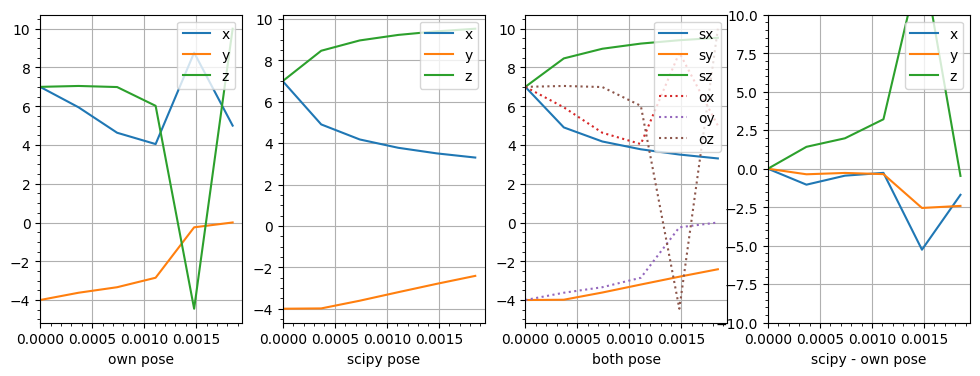

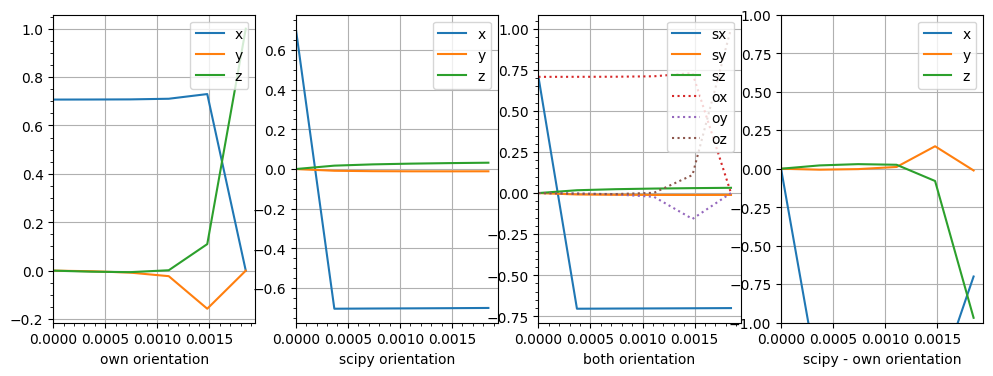

In [64]:
figure, ax = plt.subplots(1,4, figsize=(12, 4))

plot_est_p = []
plot_act_p = []
for t, solution in zip(times, soly):
    own_sol_est_R = solution[9:18]
    own_sol_est_p_bar = solution[18:21]
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(own_sol_est_R).reshape((3,3)))), own_sol_est_p_bar)
    plot_est_p.append(p_temp.tolist())
    plot_act_p.append(p.tolist())
scipy_plot_est_p = []
scipy_plot_act_p = []
for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
    scipy_plot_est_p.append(p_temp.tolist())
    scipy_plot_act_p.append(p.tolist())
ax[0].plot(times[:len(soly)], np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"])
ax[0].legend(loc="upper right")
ax[0].set_xlabel("own pose")
ax[0].grid()
ax[0].set_xlim(0)
ax[0].minorticks_on()

ax[1].plot(times[:len(soly)], np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p), label=["x", "y", "z"])
ax[1].legend(loc="upper right")
ax[1].set_xlabel("scipy pose")
ax[1].grid()
ax[1].set_xlim(0)
ax[1].minorticks_on()

ax[2].plot(times[:len(soly)], np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p), label=["sx", "sy", "sz"])
ax[2].plot(times[:len(soly)], np.array(plot_act_p)-np.array(plot_est_p), linestyle=':',label=["ox", "oy", "oz"])
ax[2].set_xlabel("both pose")
ax[2].set_xlim(0)
ax[2].legend(loc="upper right")
ax[2].grid()
ax[2].minorticks_on()

ax[3].plot(times[:len(soly)], (np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p))-(np.array(plot_act_p)-np.array(plot_est_p)), label=["x", "y", "z"])
ax[3].set_xlabel("scipy - own pose")
ax[3].set_xlim(0)
ax[3].set_ylim(-lim, lim)
ax[3].legend(loc="upper right")
ax[3].grid()
ax[3].minorticks_on()
plt.show()

figure, ax = plt.subplots(1,4, figsize=(12, 4))

plot_err_lambda_bar = []
plot_act_lambda_bar = []
plot_est_lambda_bar = []
for idx, (t, solution) in enumerate(zip(times, soly)):
    own_sol_R = solution[:9]
    own_sol_est_R = solution[9:18]
    err = np.matmul(np.linalg.inv(np.array(own_sol_est_R).reshape((3,3))), np.array(own_sol_R).reshape((3,3)))
    est = ScipyRot.from_matrix(np.array(own_sol_est_R).reshape((3,3)))
    act = ScipyRot.from_matrix(np.array(own_sol_R).reshape((3,3)))
    err = ScipyRot.from_matrix(err)
    err = err.as_quat().tolist()
    est = est.as_quat().tolist()
    act = act.as_quat().tolist()
    plot_err_lambda_bar.append(err)
    plot_est_lambda_bar.append(est)
    plot_act_lambda_bar.append(act)


scipy_plot_err_lambda_bar = []
scipy_plot_act_lambda_bar = []
scipy_plot_est_lambda_bar = []
for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
    err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
    est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
    act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
    err = ScipyRot.from_matrix(err)
    err = err.as_quat().tolist()
    est = est.as_quat().tolist()
    act = act.as_quat().tolist()
    scipy_plot_err_lambda_bar.append(err)
    scipy_plot_est_lambda_bar.append(est)
    scipy_plot_act_lambda_bar.append(act)

ax[0].plot(times[:len(soly)], np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
ax[0].legend(loc="upper right")
ax[0].set_xlabel("own orientation")
ax[0].grid()
ax[0].set_xlim(0)
ax[0].minorticks_on()

ax[1].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
ax[1].legend(loc="upper right")
ax[1].set_xlabel("scipy orientation")
ax[1].grid()
ax[1].set_xlim(0)
ax[1].minorticks_on()

ax[2].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["sx", "sy", "sz"])
ax[2].plot(times[:len(soly)], np.array(plot_err_lambda_bar)[:,0:3], linestyle=':',label=["ox", "oy", "oz"])
ax[2].legend(loc="upper right")
ax[2].set_xlabel("both orientation")
ax[2].grid()
ax[2].set_xlim(0)
ax[2].minorticks_on()

ax[3].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3] - np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
ax[3].set_xlabel("scipy - own orientation")
ax[3].set_xlim(0)
ax[3].set_ylim(-limo, limo)
ax[3].legend(loc="upper right")
ax[3].grid()
ax[2].minorticks_on()
plt.show()

In [17]:
# import pandas as pd
# df = pd.DataFrame(np.array(soly))
# df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_own_rk45_sim5_without_noise.txt', sep='\t', index=False, header=False)